In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

import numpy as np
import skimage as sk
import skimage.io as skio

import sklearn.model_selection as le_ms
import sklearn.preprocessing as le_pr
import sklearn.linear_model as le_lm
import sklearn.metrics as le_me

import tensorflow.keras.applications.inception_v3 as ki3

import assign07 as a07

from importlib import reload
reload(a07);

### Create the dataset

In [12]:
IMG_DIR = "data_assignment07/imgs"
groundTruthFr = pd.read_csv("./data_assignment07/messidorGroundTruth2.csv")

lbl = (groundTruthFr["retinopathy"] == 0) | (groundTruthFr["retinopathy"] > 2)
y = (groundTruthFr[lbl]["retinopathy"].values > 0).astype(int)

groundTruthFr = groundTruthFr[lbl]

/Users/cmokashi/miniconda3/envs/bmi6331/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [83]:
funcObj = a07.DL()
X = np.array([funcObj.cropImg(skio.imread(os.path.join(IMG_DIR, filename))) for filename in groundTruthFr["image"].tolist()])

### Transfer Learning as a feature extractor

In [4]:
iv3 = ki3.InceptionV3(include_top=False, pooling="avg")
iv3.summary()

2022-11-09 15:50:50.167591: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:50:50.167959: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [84]:
X = X * 255

X = ki3.preprocess_input(X)

In [85]:
X_iv3 = iv3.predict(X)

In [86]:
N_SPLITS = 10
kfold = le_ms.KFold(n_splits=N_SPLITS)

yPredictionArr = np.zeros(len(y))
yPredictionArr[:] = -1

X_copy = X_iv3.copy()

for train_index, test_index in kfold.split(range(len(y))):

    trainX = X_copy[train_index, :]
    trainY = y[train_index]
    testX = X_copy[test_index, :]
    testY = y[test_index]

    # scaler = le_pr.RobustScaler(with_centering=True, )
    mod1 = le_lm.LogisticRegression(penalty="l1", C=0.5, solver="liblinear")
    mod1.fit(trainX, trainY)
    yPredictionArr[test_index] = mod1.predict_proba(testX)[:, 1]

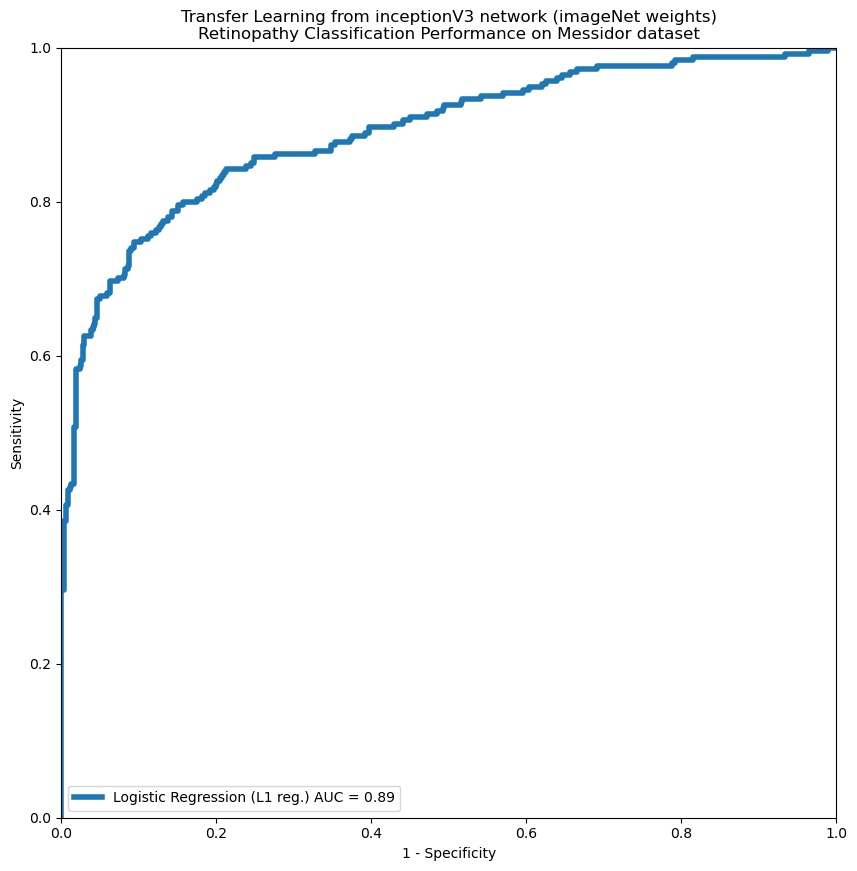

In [98]:
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = le_me.roc_curve(y, yPredictionArr, pos_label=True)
roc_auc = le_me.auc(fpr, tpr)

plt.plot(fpr, tpr, "-", label=f"Logistic Regression (L1 reg.) AUC = {round(roc_auc, 3)}", linewidth=4)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("Transfer Learning from inceptionV3 network (imageNet weights)\nRetinopathy Classification Performance on Messidor dataset")
plt.legend(loc="lower left");